### Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from ucimlrepo import fetch_ucirepo

### Loading Dataset

In [24]:
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 

# data (as pandas dataframes) 
dataset = air_quality.data.features

In [25]:
dataset.drop(columns=['Date', 'Time'], inplace=True)
dataset.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


### Data Preprocessing

In [26]:
# Missing Values
missing_values = dataset.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [27]:
# Check for duplicates
duplicates = dataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates if any
if duplicates > 0:
    dataset.drop_duplicates(inplace=True)
    print("Duplicates have been dropped.")
else:
    print("No duplicates found.")

Number of duplicate rows: 31
Duplicates have been dropped.


In [28]:
# Selected Features Dataset

X = dataset.drop('CO(GT)', axis=1)
y = dataset['CO(GT)']

### Feature Selection

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
selector = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_selected = selector.fit_transform(X, y)
X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.support_])
print("Selected features:")
print(X_selected.columns.tolist())

Selected features:
['NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


### Train test Split

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

### Feature Scaling

In [31]:
from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [32]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
# y_train_scaled = pd.DataFrame(y_train_scaled, columns=['target'])
# y_test_scaled = pd.DataFrame(y_test_scaled, columns=['target'])
X_train_scaled.head()

,NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S5(O3),T,RH,AH
0,-0.291045,0.073091,-0.364057,-1.437450,0.224540,-2.045024,-0.357305,0.251848,0.352233,0.207006
1,-0.291045,0.132317,-0.039387,0.304510,-0.289391,0.607760,0.012845,-0.147263,0.810275,0.187588
2,-0.291045,-4.990719,-3.238865,-0.442044,-3.122276,0.070887,-2.593632,-4.964933,-4.773853,-5.073025
3,-0.291045,0.001527,-0.854014,-1.437450,1.305674,-2.045024,-0.383745,0.091259,0.282531,0.192839
4,-0.291045,0.021269,-0.706437,-1.437450,1.186593,-2.045024,-0.650341,0.077090,0.481679,0.195922


### Artificial Neural Network Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import mean_squared_error

model = Sequential()

model.add(Dense(units=256, input_shape=(X_train_scaled.shape[1],)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(units=128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(units=64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(units=32))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=0.0001)

# Train the ANN
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test),
                    epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss_ann, mae_ann = model.evaluate(X_test_scaled, y_test)
mse_ann = mean_squared_error(y_test, model.predict(X_test_scaled))
rmse_ann = mse_ann ** 0.5

print(f"Loss: {loss_ann}")
print(f"Mean Absolute Error (MAE): {mae_ann}")
print(f"Mean Squared Error (MSE): {mse_ann}")
print(f"Root Mean Squared Error (RMSE): {rmse_ann}")


e:\Free Lancing\ML and DL\Project1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
e:\Free Lancing\ML and DL\Project1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
467/467 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4363.2588 - mae: 34.3851 - val_loss: 3024.9280 - val_mae: 30.0961 - learning_rate: 0.0010
Epoch 2/100
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2981.5405 - mae: 29.4912 - val_loss: 2969.7341 - val_mae: 28.9434 - learning_rate: 0.0010
Epoch 3/100
467/467 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2889.9536 - mae: 28.8563 - val_loss: 2905.2415 - val_mae: 28.5768 - learning_rate: 0.0010
Epoch 4/100
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2875.2598 - mae: 28.2778 - val_loss: 2940.1294 - val_mae: 29.0418 - learning_rate: 0.0010
Epoch 5/100
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2761.3279 - mae: 27.6446 - val_loss: 2843.3738 - val_mae: 28.5685 - learning_rate: 0.0010
Epoch 6/100
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2865.7517 - mae: 28.5184 - val_loss: 2854.6963 - val_mae: 27.1004 - learning_rate: 0.0010
Epoch 7/100
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2724.8882 - mae: 27.6716 - val_lo

### Decision Tree Regression

In [34]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = dt_model.predict(X_test_scaled)

# Calculate loss (mean squared error) and mean absolute error
dt_loss = mean_squared_error(y_test, y_pred)
dt_mae = mean_absolute_error(y_test, y_pred)
dt_mse = mean_squared_error(y_test, y_pred)
dt_rmse = dt_mse ** 0.5

print(f"Decision Tree Loss (MSE): {dt_loss}")
print(f"Decision Tree Mean Absolute Error (MAE): {dt_mae}")
print(f"Decision Tree Mean Squared Error (MSE): {dt_mse}")
print(f"Decision Tree Root Mean Squared Error (RMSE): {dt_rmse}")

Decision Tree Loss (MSE): 4665.656747052519
Decision Tree Mean Absolute Error (MAE): 23.501554126473742
Decision Tree Mean Squared Error (MSE): 4665.656747052519
Decision Tree Root Mean Squared Error (RMSE): 68.30561285174534


### Random Forest Regression

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculate loss (mean squared error) and mean absolute error
rf_loss = mean_squared_error(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = rf_mse ** 0.5

print(f"Random Forest Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest Root Mean Squared Error (RMSE): {rf_rmse}")

print(f"Random Forest Loss (MSE): {rf_loss}")
print(f"Random Forest Mean Absolute Error (MAE): {rf_mae}")

Random Forest Mean Squared Error (MSE): 2538.1523586913318
Random Forest Root Mean Squared Error (RMSE): 50.38007898655312
Random Forest Loss (MSE): 2538.1523586913318
Random Forest Mean Absolute Error (MAE): 24.46900404667292


### Visualization Graphs

#### MAE

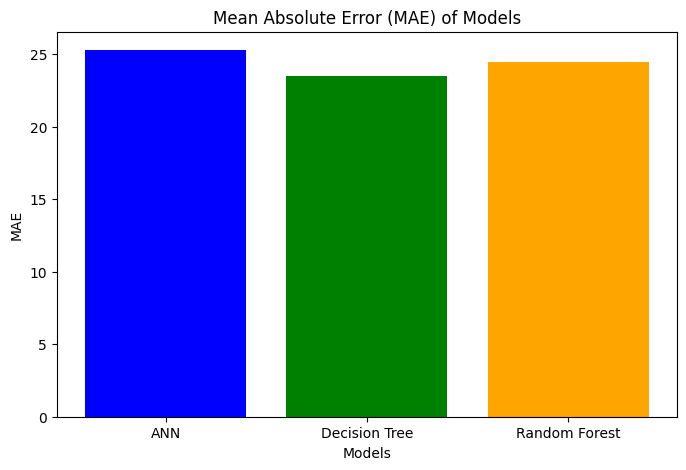

In [36]:
import matplotlib.pyplot as plt

# Define the MAE values and corresponding model names
mae_values = [mae_ann, dt_mae, rf_mae]
model_names = ['ANN', 'Decision Tree', 'Random Forest']

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, mae_values, color=['blue', 'green', 'orange'])
plt.title('Mean Absolute Error (MAE) of Models')
plt.ylabel('MAE')
plt.xlabel('Models')
plt.show()

#### Loss

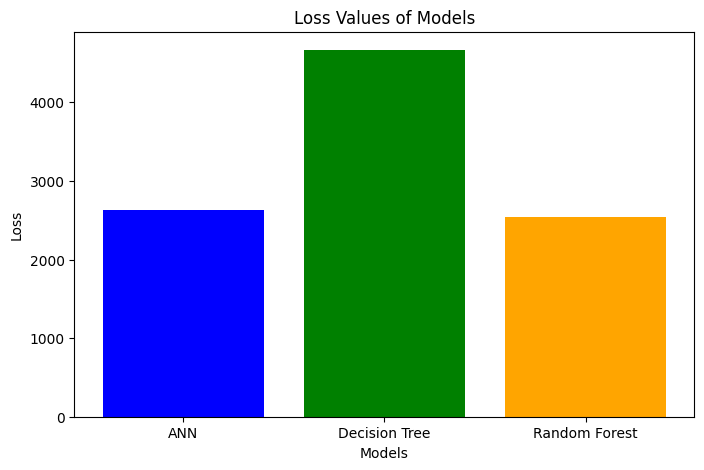

In [37]:
# Define the loss values and corresponding model names
loss_values = [loss_ann, dt_loss, rf_loss]
model_names = ['ANN', 'Decision Tree', 'Random Forest']
colors = ['blue', 'green', 'orange']

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, loss_values, color=colors)
plt.title('Loss Values of Models')
plt.ylabel('Loss')
plt.xlabel('Models')
plt.show()

#### MSE

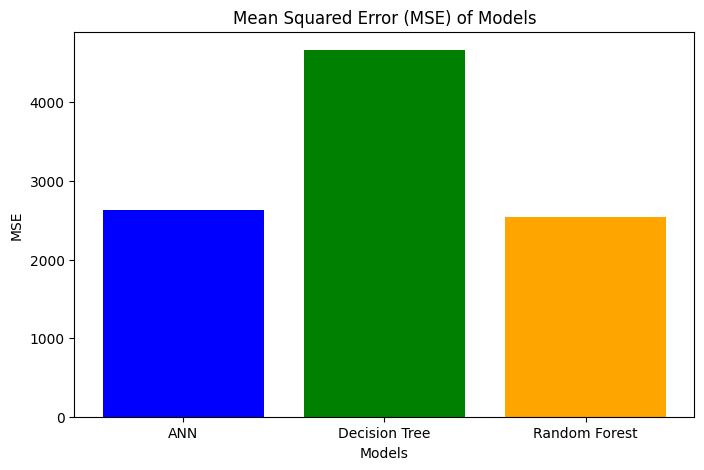

In [38]:
# Define the MSE values and corresponding model names
mse_values = [mse_ann, dt_mse, rf_mse]
model_names = ['ANN', 'Decision Tree', 'Random Forest']
colors = ['blue', 'green', 'orange']

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, mse_values, color=colors)
plt.title('Mean Squared Error (MSE) of Models')
plt.ylabel('MSE')
plt.xlabel('Models')
plt.show()

#### RMSE

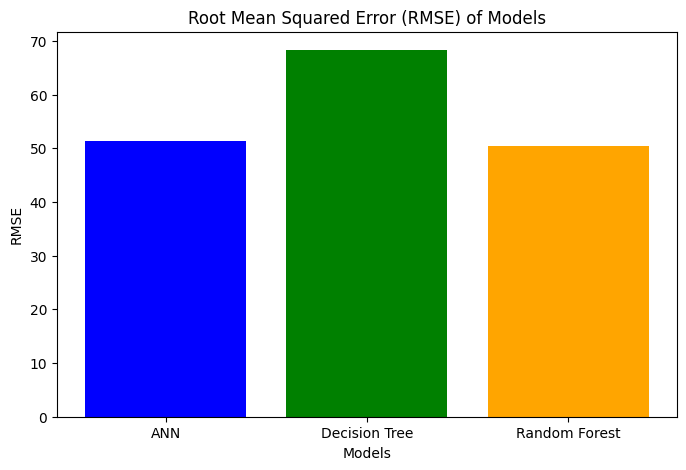

In [39]:
# Define the RMSE values and corresponding model names
rmse_values = [rmse_ann, dt_rmse, rf_rmse]
model_names = ['ANN', 'Decision Tree', 'Random Forest']
colors = ['blue', 'green', 'orange']

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, rmse_values, color=colors)
plt.title('Root Mean Squared Error (RMSE) of Models')
plt.ylabel('RMSE')
plt.xlabel('Models')
plt.show()

### Loss Plot

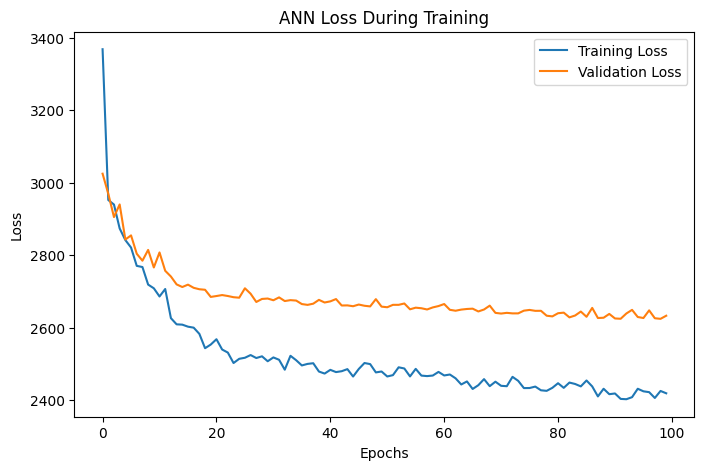

In [40]:
# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
To determine which model performed well, we can compare their evaluation metrics such as **Mean Absolute Error (MAE)**, **Mean Squared Error (MSE)**, and **Root Mean Squared Error (RMSE)**. Lower values for these metrics indicate better performance.

### Model Performance Summary:
- **ANN (Artificial Neural Network):**
    - MAE: 25.28
    - MSE: 2633.04
    - RMSE: 51.31

- **Decision Tree:**
    - MAE: 23.50
    - MSE: 4665.66
    - RMSE: 68.31

- **Random Forest:**
    - MAE: 24.47
    - MSE: 2538.15
    - RMSE: 50.38

### Best Performing Model:
The **Random Forest Regressor** performed the best overall because:
1. It has the **lowest MSE (2538.15)** and **lowest RMSE (50.38)**, indicating better prediction accuracy.
2. Although its MAE (24.47) is slightly higher than the Decision Tree's MAE (23.50), the Random Forest's lower MSE and RMSE make it more reliable for minimizing large errors.

### Why Random Forest Performed Well:
- Random Forest is an ensemble method that combines multiple decision trees, reducing overfitting and improving generalization.
- It captures complex relationships in the data better than a single Decision Tree.
- It is robust to noise and missing data, which might be present in the dataset.